# Problem Set 2 - Naive Bayes, Decision Trees with ensemble methods
## CSCI 5622 - Fall 2021
***
**Name**: $<$Ragul Venkataraman Ravisankar$>$ 
***

This assignment is due on Canvas by **3:55PM on October 7th**.

Submit only this Jupyter notebook to Canvas. Do not compress it using tar, rar, zip, etc.
Your solutions to analysis questions should be done in Markdown directly below the associated question.

Remember that you are encouraged to discuss the problems with your classmates and instructors, 
but **you must write all code and solutions on your own**, and list any people or sources consulted.
The only exception to this rule is that you may copy code directly from your own solution to homework 1.
***

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Overview 

Your task for this homework is to build a naive Bayes and a decision tree classifiers in the first 2 problems.
The last problem is about ensemble methods using scikit-learn decision tree as a weak learner.
We'll explore bagging, boosting (AdaBoost) and Random Forest.

In [ ]:
import numpy as np
import matplotlib.pylab as plt
import pickle
from sklearn.metrics import precision_score
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
from time import time
import seaborn as sns
import math
import random
%matplotlib inline 

### Problem 1 - Naive Bayes [25 points]
***
Consider the problem of predicting whether a person has a college degree based on age, salary, and Colorado residency.
The dataset looks like the following.

|Age|Salary|Colorado Residency| College degree|
|:------:|:-----------:| :----------:|--:|
| 27 | 41,000 | Yes | Yes |
| 61 | 52,000 | No | No |
| 23 | 24,000 | Yes | No |
| 29 | 77,000 | Yes | Yes |
| 32 | 48,000 | No | Yes |
| 57 | 120,000 | Yes | Yes |
| 22 | 38,000 | Yes | Yes |
| 41 | 45,000 | Yes | No |
| 53 | 26,000 | No | No |
| 48 | 65,000 | Yes | Yes |


In [ ]:
features = np.array([[27 , 41000 , 1],
              [61 , 52000 , 0],
              [23 , 24000 , 1],
              [29 , 77000 , 1],
              [32 , 48000 , 0],
              [57 , 120000 , 1],
              [22 , 38000 , 1],
              [41 , 45000 , 1],
              [53 , 26000 , 0],
              [48 , 65000 , 1]])
labels = np.array([1, 0, 0, 1, 1, 1, 1, 0, 0, 1])
print(features.shape)

(10, 3)


1.1 What is our expected accuracy for the baseline case where we predict one label for all rows? (*2 points*)

If we predict Yes for all the cases we get the accuracy of 60% and if we predict No for all cases we get the accuracy of 40%. Since yes has higher accuracy, if we predict yes for all cases we get the accuracy score of 60% which is the baseline case.

#BEGIN Workspace 1.1

#TODO: accuracy of the baseline using no features

#END Workspace 1.1

First, we have to find a way to deal with the continuous features. For now, let's put them into binary bins based on threshold arguments to our classifier - so we can treat this as a tuning parameter.

1.2 Complete `threshold_features` to convert age and salary features to binary ones using the threshold arguments. (*3 points*)

In [ ]:
def threshold_features(features, age_threshold, salary_threshold):
    binary_X = features * 1 #This row just creates a "hard copy" of the X array so we can manipulate it as needed

    #BEGIN Workspace 1.2
    #TODO: Threshold the corresponding features
    
    for i in range(len(binary_X)):
      if binary_X[i][0]<age_threshold:
        binary_X[i][0] = 0
      else:
        binary_X[i][0] = 1  

      if binary_X[i][1]<salary_threshold:
        binary_X[i][1] = 0
      else:
         binary_X[i][1] = 1   

    #END Workspace 1.2

    return binary_X

As seen during the class, given a row $(x_1, x_2, x_3)$, the naive Bayes classifier should assign the label $y$ that
maximizes:

\begin{align}
\log [p(y) \prod_i p(x_i | y)] = \log p(y) + \sum_{i} \log p(x_i | y)
\end{align}

$p(y)$ and $p(x_i | y)$ are computed using the training set (during `fit` call).

We have defined $p(x_i | y)$ as :
\begin{align}
p(x_i | y) = \frac{N_{y,i}}{N_y}
\end{align}
where $N_{y,i}$ is the number of rows where $y$ and $x_i$ occur together, and $N_y = \sum_i N_{y,i}$.

1.3 Complete the `fit` call by computing the counts and joint counts. Hint: Use `features_counts` to store the contingency
table $N_{y,i}$ for each feature $i$ and then use them to compute $\log p(x_i | y)$ (*10 points*)

1.4 Complete the `predict` call (*5 points*)

In [ ]:
class NaiveBayes(object):
    """
    NaiveBayes classifier for binary features and binary labels
    """

    def __init__(self, alpha=0.0):
        self.alpha = alpha
        self.classes_counts = None
        self.features_counts = []
        self.classes_log_probabilities = None
        self.features_log_probabilities = [] # same structure as features_count

    def fit(self, X, y):
        """

        Parameters
        ----------
        X: binary np.array of shape (n_samples, n_features)
        y: corresponding labels of shape (n_samples,)
        Returns
        -------
        Trained classifier
        """

        #BEGIN Workspace 1.3

        #TODO: Compute the counts and joint counts
        self.classes_counts = np.zeros(2,)
        self.features_counts = np.zeros((3,2,2))
        self.features_log_probabilities = np.zeros((3,2,2))
        self.classes_log_probabilities = np.zeros(2,)

        #computing feature counts
        for i in range(len(X[0])):
          for j in range(len(X)):
            self.features_counts[i][X[j][i]][y[j]]+=1


        #computing value counts
        for i in range(len(y)):
          self.classes_counts[y[i]]+=1


        for i in range(3):
          for j in range(2):
            for k in range(2):
              numerator = self.features_counts[i][j][k] + self.alpha
              denominator = self.classes_counts[k] + (self.alpha * 2)
              temp = (numerator/denominator) #to handle unseen data I am using laplace smoothing here
              self.features_log_probabilities[i][j][k] = math.log(temp) 
              
        for i in range(len(self.classes_counts)):
          temp = self.classes_counts[i]/len(y)
          self.classes_log_probabilities[i] = math.log(temp)       
        #END Workspace 1.3
        return self

    def predict(self, x_test):
        #BEGIN Workspace 1.4
        #TODO: Find the corresponding labels using Naive bayes logic
        # zero_probability = self.classes_log_probabilities[0]
        # one_probability = self.classes_log_probabilities[1]
        joint_log_likelihood = np.zeros((x_test.shape[0], self.classes_counts.shape[0]))
        y_hat = 0
        y_predicted = []
        zero_probability = 0
        one_probability = 0

        for i in range(len(x_test)):
          zero_probability = self.classes_log_probabilities[0]
          one_probability = self.classes_log_probabilities[1]
          for j in range(len(x_test[0])):
            feature_value = x_test[i][j]
            zero_probability = zero_probability + self.features_log_probabilities[j][feature_value][0]
            one_probability = one_probability + self.features_log_probabilities[j][feature_value][1]
          if zero_probability >= one_probability:
            y_predicted.append(0)
          else:
            y_predicted.append(1)

        #END Workspace 1.4
        return y_predicted


1.5 Using age 30 and salary 40,000 as thresholds, transform the features and evaluate (accuracy) the NaiveBayes classifier
on the training data. (*5 points*)

In [ ]:
#BEGIN Workspace 1.5
#TODO: Transform features to binary features, fit the classifier, report the accuracy
clf = NaiveBayes(2)#laplace smoothing
new_features = threshold_features(features,30,40000)
clf.fit(new_features,labels)
y_predicted = clf.predict(new_features)


error_count = 0;
for i in range(len(y_predicted)):
  if labels[i]!=y_predicted[i]:
    error_count+=1

accuracy = ((len(y_predicted) - error_count)/len(y_predicted))*100
print('The accuracy is :: ',accuracy, '%')

#END Workspace 1.5

The accuracy is ::  70.0 %


**Bonus question** 1.6 Use the attribute `alpha` of the NaiveBayes to convert it to the smoothed NaiveBayes presented during the class. (*5 points*)

### Problem 2 - Decision trees [25 points]
***
The goal of this problem is to implement the core elements of the Decision Tree classifier.
We do not expect a highly efficient implementation of the functions since the ensemble methods will use the implementation
from scikit-learn.

We start by considering the variable *Colorado residency*.

The leaf nodes of a decision tree act in the same way as in question (1.1) where no feature is used.

2.1 Complete `get_error_in_leaf` to return the count of misclassified instances. (*3 points*)

In [ ]:
def compute_left_right_children(X,feature_index,threshold):
  left_child = []
  right_child = []
  for idx in range(len(X)):
    if X[idx][feature_index]<=threshold:
      left_child.append(idx)
    else:
      right_child.append(idx)

  return left_child,right_child

In [ ]:
def compute_left_right_children_with_indices(X,feature_index,value_index,threshold):
  left_child = []
  right_child = []
  for idx in value_index:
    if X[idx][feature_index]<=threshold:
      left_child.append(idx)
    else:
      right_child.append(idx)

  return left_child,right_child

In [ ]:
def get_error_in_leaf(y, indices):
    """
    :param y: all labels
    :param indices: the subset of indexes in the leaf node
    :return: Returns the number of errors in a leaf node of a decision tree.
    """

    error_count = 0
    #BEGIN Workspace 2.1
    #TODO: Compute the number of errors in the leaf node (no feature is used)
    y_values_of_leaf_node = []
    for idx in indices:
      y_values_of_leaf_node.append(y[idx])

    error_count = min(y_values_of_leaf_node.count(0), y_values_of_leaf_node.count(1)) #returning the minimum number of class points
    #END Workspace 2.1
    return error_count


def value_split_binary_feature(x, y, feature_index, root, criteria_func):
    """Will be used later to evaluate the criteria gain"""
    left_child = [i for i in root if x[i, feature_index] == 0]
    right_child = [i for i in root if x[i, feature_index] == 1]
    return criteria_func(y, root, left_child, right_child)


We will use information gain criteria to decide how to split the root node of our decision tree.

2.2 Complete the `entropy` function. (*5 points*)

2.3 Complete the `information_gain_criteria` to compute the information gained by splitting the root node.
 Print the gain value for splitting based on *Colorado residency* (*5 points*)


In [ ]:
def entropy(y, indices):

    """
    :param y: all labels
    :param indices: the indices of data points
    :return: Returns the entropy in the labels for the data points in indices.
    """
    
    entropy_value = 0
    if len(indices) == 0: # deal with corner case when there is no data point.
        return entropy_value
    else:
        #BEGIN Workspace 2.2
        #TODO: Compute the entropy of the labels from indices
      y_values_of_leaf_node = []
      zero_probability = 0
      one_probability = 0
      for idx in indices:
        y_values_of_leaf_node.append(y[idx])
      
      zero_probability = y_values_of_leaf_node.count(0)/len(y_values_of_leaf_node)   
      one_probability = y_values_of_leaf_node.count(1)/len(y_values_of_leaf_node)

      if zero_probability > 0:
        entropy_value = entropy_value + (zero_probability * np.log(zero_probability))
      if one_probability > 0:
        entropy_value = entropy_value + (one_probability * np.log(one_probability))
      
      entropy_value = -1 * entropy_value 
        #END Workspace 2.2
      return entropy_value

def information_gain_criteria(y, root, left_child, right_child):
    """
    :param y: all labels
    :param root: indices of all the data points in the root
    :param left_child: the subset of indices in the left child
    :param right_child: the subset of indices in the right child
    :return: information gain of the split
    """
    
    #BEGIN Workspace 2.3.a
    #TODO: Compute the information gain of the split
    information_gain = 0
    entropy_parent = entropy(y,root)
    entropy_child = ((len(left_child)/len(root))*entropy(y,left_child)) + ((len(right_child)/len(root))*entropy(y,right_child))
    information_gain = entropy_parent - entropy_child
    #END Workspace 2.3.a
    return information_gain

In [ ]:

#BEGIN Workspace 2.3.b
#TODO: report the information gain of the split based on Colorado Residency
feature_id = 2
root = []
left_child = []
right_child = []

for idx in range(len(features)):
  root.append(idx)
  if features[idx][feature_id]==0:
    left_child.append(idx)
  else:
    right_child.append(idx)  

info_gain = information_gain_criteria(labels,root,left_child,right_child)
print('Information gain from Colorado residency feature ', info_gain)

#END Workspace 2.3.b

Information gain from Colorado residency feature  0.06326870451113265


Now we have to deal with continuous features for the decision tree.
One way to deal with continuous (or ordinal) data is to define binary features based on thresholding as we've done
for NaiveBayes. But we have to find the optimal threshold based on the criteria we're using.

2.4 Complete the `value_split_continuous_feature` by trying different possible threshold values of feature
of index `feature_index` and return the best criteria value and threshold. (*5 points*)

In [ ]:
def value_split_continuous_feature(x, y, feature_index, root, criteria_func=information_gain_criteria):
    """
    :param x: all feature values
    :param y: all labels
    :param feature_index: feature id to split the tree based on
    :param root: indexes of all the data points in the root
    :param criteria_func: the splitting criteria function
    :return: Return the best value and its corresponding threshold by splitting based on a continuous feature.
    """

    best_value, best_thres = 0, 0

    #BEGIN Workspace 2.4
    #TODO: Complete the function as detailed in the question and function description

    for threshold_idx in range(len(x)):
      left_child = []
      right_child = []
      computed_info_gain = 0
      for idx in root:
        if x[idx][feature_index]<=x[threshold_idx][feature_index]:
          left_child.append(idx)
        else:
          right_child.append(idx)
    
      computed_info_gain = criteria_func(y,root,left_child,right_child)
      if computed_info_gain > best_value:
        best_value = computed_info_gain
        best_thres = x[threshold_idx][feature_index]

    #END Workspace 2.4
    return best_value, best_thres

2.5 Find the best thresholds for age and salary. Print their corresponding information gains. (*5 points*)

In [ ]:
root = list(range(len(labels))) # root includes all data points
#BEGIN Workspace 2.5
#TODO: Report the best thresholds for age and salary and their split information gains

#For Salary
print('For Salary feature')
best_value, best_threshold = value_split_continuous_feature(features,labels,1,root)
print('The Information gain is :: ',best_value)
print('The best threshold value is ::', best_threshold)
print('\n')


#For Age
print('For Age feature')
best_value, best_threshold = value_split_continuous_feature(features,labels,0,root)
print('The Information gain is :: ',best_value)
print('The best threshold value is ::', best_threshold)
print('\n')
#END Workspace 2.5

For Salary feature
The Information gain is ::  0.22314355131420988
The best threshold value is :: 26000


For Age feature
The Information gain is ::  0.10014891554392502
The best threshold value is :: 57




2.6 Based on the obtained information gains, if we build a decision stump (decision tree with depth 1) greedily,
which feature should we choose? Why? What's the resulting accuracy? (*2 points*)



#BEGIN Workspace 2.6.a

If we want to build a descision stump I would choose the salary feature to build a decision stump because it has the highest information gain (0.32) out of the three features. Colorado residency has the lowest information gain of 0.09 whereas the age feature has the information gain of 0.144. Therefore I will choose salary feature if I were to build the decision stump.

#END Workspace 2.6.a

In [ ]:
def compute_accuracy_dt(features_len,error):
  accuracy = ((features_len - error)/features_len)*100
  return accuracy

In [ ]:
#BEGIN Workspace 2.6.b
#TODO: Split based on the chosen feature and compute the accuracy (use get_error_in_leaf)
left_child, right_child = compute_left_right_children(features, 1, 26000)
left_error = get_error_in_leaf(labels, left_child)
right_error = get_error_in_leaf(labels,right_child)

accuracy = compute_accuracy_dt(len(features),left_error + right_error)
print('The accuracy percentage is :: ', accuracy)
#END Workspace 2.6.b

The accuracy percentage is ::  80.0


**Bonus Question**

2.7 You now have all the ingredients to build a decision tree recursively.
You can build a decision tree of depth two and report its classification error on the training data and the tree.(*5 points*)

In [ ]:
# #BEGIN Workspace 2.7
# #TODO: Build a Decision Tree of Depth 2 using age, salary and the previously computed thresholds


#using the previously computed thresholds
def recursive_dt(root,current_depth,feature_index,threshold):
  if current_depth == 2:
    return get_error_in_leaf(labels,root)
  left_child, right_child = compute_left_right_children_with_indices(features,feature_index, root, threshold)  
  left_error = recursive_dt(left_child, current_depth+1, 0, 57)
  right_error = recursive_dt(right_child, current_depth+1, 0, 57)
  return left_error+right_error

error_count = recursive_dt(root,0,1,26000)
print('The accuracy is :: ',compute_accuracy_dt(len(features),error_count), '%')
# #END Workspace 2.7

The accuracy is ::  90.0 %


Problem 3  - Decision Tree Ensembles: Bagging and Boosting [50 points]
---

We are going to predict house price levels using decision tree ensembles.

In this classification problem, we compare Decision trees and it's ensembles - Bagging and Boosting on House Price prediction [dataset](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data)

Our *weak learner* for this problem is the DecisionTreeClassifier from scikit-learn with `max_depth=10`.

We start first by loading preprocessed data that we'll use. Since the original data is for regression, we have first to transform
`y_train` and `y_test` to discrete values reflecting price level.

|Price range| Label|
|:----------:|--:|
| $ P < $125000|0|
|125000$\leq P < $ 160000| 1 |
|160000$ \leq P < $ 200000| 2 |
|200000$ \leq P $ | 3 |

3.1 Start by transforming`y_train` and `y_test` to discrete values using the provided ranges. (*3 points*)

In [ ]:
def threshold_transform(Y):
  for idx in range(len(Y)):
    if Y[idx]<125000:
      Y[idx] = 0
    elif Y[idx]>=125000 and Y[idx]<160000:
      Y[idx]=1
    elif Y[idx]>=160000 and Y[idx]<200000:
      Y[idx]=2
    else:
      Y[idx]=3
  return Y;

In [ ]:
def compute_confusion_matrix(y_predicted, y_actual):
  c_matrix = np.array(None)
  accuracy_score = 0
  SIZE = len(set(y_actual))
  c_matrix = np.zeros((SIZE,SIZE), dtype=int)
  for predicted, actual in zip(y_predicted, y_actual):
    c_matrix[predicted][actual]+=1;
  return c_matrix  

In [ ]:
def compute_accuracy(y_predicted, y_actual):
  c_matrix = np.array(None)
  accuracy_score = 0
  c_matrix = compute_confusion_matrix(y_predicted, y_actual)
  accuracy_score = np.sum(c_matrix.diagonal())/c_matrix.sum() 
  return accuracy_score

In [ ]:
def compute_precision_micro_average(y_predicted, y_actual):
  c_matrix = np.array(None)
  c_matrix = compute_confusion_matrix(y_predicted, y_actual)
  row_sum = c_matrix.sum(axis=1)
  numerator = 0
  for i in range(len(c_matrix)):
    for j in range(len(c_matrix)):
      if i!=j: continue
      else:
        numerator = numerator + c_matrix[i][j];
        row_sum[i] = row_sum[i] - c_matrix[i][j];

  denominator = np.sum(row_sum) + numerator;
  micro_precision_score = numerator/denominator;
  return micro_precision_score;

In [ ]:
def compute_precision_macro_average(y_predicted, y_actual):
  c_matrix = np.array(None)
  c_matrix = compute_confusion_matrix(y_predicted, y_actual)
  row_sum = c_matrix.sum(axis=1);
  macro_precision_score = 0;
  SIZE = len(set(y_actual))
  for i in range(len(c_matrix)):
    for j in range(len(c_matrix)):
      if i!=j: continue
      else:
        macro_precision_score = macro_precision_score + (c_matrix[i][j]/row_sum[i]) 
  macro_precision_score = macro_precision_score/len(set(y_actual))
  return macro_precision_score     

In [ ]:
def precision_score(y_predicted, y_actual, average):
  if average.lower() == 'micro':
    return compute_precision_micro_average(y_predicted, y_actual)
  else:
    return compute_precision_macro_average(y_predicted, y_actual)

In [ ]:
X_train, X_test, y_train, y_test = pickle.load(open('/content/drive/MyDrive/PS2_Base_5622/data/test_train.pkl','rb'))

In [ ]:
#BEGIN Workspace 3.1
#TODO: Discretize y_train and y_test
y_train = threshold_transform(y_train)
y_test = threshold_transform(y_test)
#END Workspace 3.1

3.2 Complete the `ensemble_test` class to `fit` the model received as parameter and store the metrics and running time. (*5 points*)

3.3 Complete `plot_metric` to show and compare different statistics of each model in a bar chart. (*5 points*)

Later we will also use `ensemble_test` class to plot score, metric and time taken to fit the data.

In [ ]:
def get_weak_learner():
    """Return a new instance of out chosen weak learner"""
    return DecisionTreeClassifier(max_depth=10)

class EnsembleTest:
    """
        Test multiple model performance
    """

    def __init__(self, x_train, y_train, x_test, y_test):
        """
        initialize data partitions
        """
        self.scores = {}
        self.execution_time = {}
        self.metric = {}
        self.x_train = X_train
        self.y_train = y_train
        self.x_test = X_test
        self.y_test = y_test
        self.score_name ='Mean accuracy'
        self.metric_name = 'Precision(micro)'

    def fit_model(self, model, name):
        """
        Fit the model on train data.
        predict on test and store score and execution time for each fit.
        :param model: model
        :param name: name of model
        """
        start = time()
        #BEGIN Workspace 3.2
        #TODO: Fit the model and get the predictions
        #       train and test data are treated as global variables
        model.fit(self.x_train, self.y_train)
        y_predicted = model.predict(self.x_test)
        Accuracy = compute_accuracy(y_predicted,self.y_test)
        self.metric[name] = Accuracy
        self.scores[name] = precision_score(y_predicted,self.y_test, "micro")

        #Hint: self.scores[name] = precision_score(?, average="micro") # in multi-class, micro implies treating it as binary precision

        #Hint self.metric[name] = Accuracy
        #END Workspace 3.2
        self.execution_time[name] = time() - start

    def print_result(self):
        """
            print results for all models trained and tested.
        """
        models_cross = pd.DataFrame({
            'Model'         : list(self.metric.keys()),
             self.score_name     : list(self.scores.values()),
             self.metric_name    : list(self.metric.values()),
            'Execution time': list(self.execution_time.values())})
        print(models_cross.sort_values(by=self.score_name, ascending=False))

    def plot_metric(self):
        #BEGIN Workspace 3.3
        #TODO: plot bar chart for each metric : time, metric, score

        plt.figure(figsize=(8,4))
        data_time_taken = pd.DataFrame({
            'Models' : self.execution_time.keys(),
            'Time_Taken' : self.execution_time.values(),
            'Accuracy' : self.metric.values(),
            'Precision' : self.scores.values()
        })
        time_plot = sns.barplot(x = data_time_taken['Models'], y= data_time_taken['Time_Taken'])
        time_plot.set_xticklabels(time_plot.get_xticklabels(),rotation=30, ha="right")
        plt.show()

        precision_plot = sns.barplot(x = data_time_taken['Models'], y = data_time_taken['Precision'])
        precision_plot.set_xticklabels(precision_plot.get_xticklabels(),rotation=30,ha="right")
        plt.show()

        accuracy_plot = sns.barplot(x = data_time_taken['Models'],  y = data_time_taken['Accuracy'])
        accuracy_plot.set_xticklabels(accuracy_plot.get_xticklabels(),rotation=30,ha="right")
        plt.show()

        #END Workspace 3.3

3.4 Test `EnsembleTest` using our weak learner returned by `get_weak_learner` (*2 points*)

             Model  Mean accuracy  Precision(micro)  Execution time
0  Decision_Tree-0       0.688356          0.688356        0.021831
1  Decision_Tree-1       0.688356          0.688356        0.020464
3  Decision_Tree-3       0.681507          0.681507        0.026601
2  Decision_Tree-2       0.678082          0.678082        0.020231
4  Decision_Tree-4       0.674658          0.674658        0.022576
6  Decision_Tree-6       0.667808          0.667808        0.020657
5  Decision_Tree-5       0.660959          0.660959        0.020541


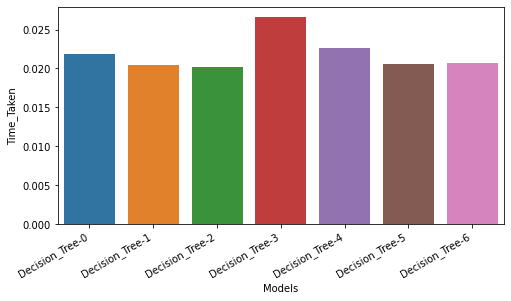

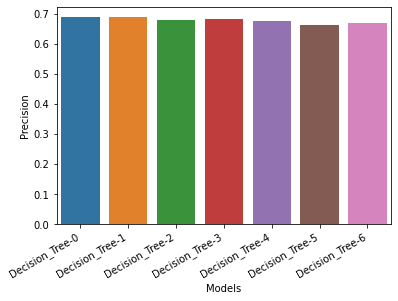

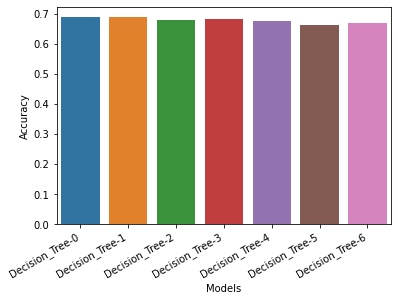

In [ ]:
# create a handler for ensemble_test, use the created handler for fitting different models.
ensemble_handler = EnsembleTest(X_train,y_train,X_test,y_test)
#BEGIN Workspace 3.4
#TODO: Initialize weak learner and fit ensemble_handler

for idx in range(0,7):
  model = get_weak_learner()
  model_name = f"Decision_Tree-{idx}"
  ensemble_handler.fit_model(model, model_name)
  

#END Workspace 3.4
ensemble_handler.print_result()
ensemble_handler.plot_metric()

**Bagging:**

Bagging consists of training a set of weak learners using random subsets of the train data.

3.5 First, complete `sample_data` to return a random sample of size `sample_ratio * len(X_train)` of features and labels (*2 points*)

3.6 Complete `fit` by building `n_estimators` of DecisionTreeClassifier, each trained on random sample of the data (*5 points*)

3.7 Complete `predict` method to return the most likely label by combining different estimators predictions. 
Use a simple majority / plurality vote system similar to the one used in your KNNClassifier in Problem Set 1. However, in this case, to break a tie you should use `predict_log_proba` or `predict_proba` method of DecisionTreeClassifier:
[Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier.predict_proba) (*2 points*)

In [ ]:
class BaggingEnsemble(object):

    def __init__(self, n_estimators, sample_ratio):
        self.n_estimators = n_estimators
        self.sample_ratio = sample_ratio
        self.estimators = []

    def sample_data(self, x_train, y_train):
        x_sample, y_sample = None, None
        
        #BEGIN Workspace 3.5
        #TODO: sample random subset of size sample_ratio * len(X_train)
        mask = np.random.rand(len(X_train)) <= self.sample_ratio

        x_sample = X_train[mask]
        y_sample = y_train[mask]
        
        #END Workspace 3.5
        return x_sample, y_sample

    def fit(self, x_train, y_train):
        for _ in range(self.n_estimators):
          #BEGIN Workspace 3.6
          #TODO: sample data and create new weak learned trained on the sample
          model = get_weak_learner();
          x_sample, y_sample = self.sample_data(x_train, y_train)
          model.fit(x_sample,y_sample)
          self.estimators.append(model)

          #END Workspace 3.6

    def predict(self, X_test):
        predicted_proba = 0
        model_answers = np.zeros((len(X_test),4))
        #BEGIN Workspace 3.7
        #TODO: go through the trained estimators and acummualte their predicted_proba to get the mostly likely label

        for model in self.estimators:
          class_probabilities = model.predict_proba(X_test)
          model_answers = np.add(model_answers,class_probabilities)

        answer = model_answers.argmax(axis=1)
        #END Workspace 3.7
        return answer


In [ ]:
# This cell should run without errors
ensemble_handler.fit_model(BaggingEnsemble(10, 0.9),'Bagging')
ensemble_handler.print_result()


             Model  Mean accuracy  Precision(micro)  Execution time
7          Bagging       0.726027          0.726027        0.204821
0  Decision_Tree-0       0.688356          0.688356        0.021831
1  Decision_Tree-1       0.688356          0.688356        0.020464
3  Decision_Tree-3       0.681507          0.681507        0.026601
2  Decision_Tree-2       0.678082          0.678082        0.020231
4  Decision_Tree-4       0.674658          0.674658        0.022576
6  Decision_Tree-6       0.667808          0.667808        0.020657
5  Decision_Tree-5       0.660959          0.660959        0.020541


**Random Forest**
Random Forest has an additional layer of randomness compared to Bagging: we also sample a random subset of the features.

3.8 First, complete `sample_data` to return a random sample of size `sample_ratio * len(X_train)` of labels and `feature_ratio * num_features` of features (*2 points*)

3.9 Complete `fit` by building `n_estimators` of DecisionTreeClassifier, each trained on random sample of the data.
Make sure to keep track of the sampled features for each estimator to use them in the prediction step. (*5 points*)

3.10 Complete `predict` method to return the most likely label by combining different estimators predictions.
Use a simple majority / plurality vote system similar to the one used in your KNNClassifier in Problem Set 1. However, in this case, to break a tie you should use `predict_log_proba` or `predict_proba`  method of DecisionTreeClassifier:
[Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier.predict_proba) (*3 points*)


In [ ]:
class RandomForest(object):
    def __init__(self, n_estimators, sample_ratio, features_ratio):
        self.n_estimators = n_estimators
        self.sample_ratio = sample_ratio
        self.features_ratio = features_ratio
        self.estimators = []
        self.features_indices = []

    def sample_data(self, x_train, y_train):
        X_sample, y_sample, features_indices = None, None, None
        #BEGIN Workspace 3.8
        #TODO: sample random subset of size sample_ratio * len(X_train) and subset of features of size
        #         features_ratio * num_features


        indices_of_data_points = set()
        indices_of_features = set()

        while len(indices_of_data_points) < (self.sample_ratio * len(x_train)):
          indices_of_data_points.add(random.randint(0,len(x_train)-1))
        
        while len(indices_of_features) < (self.features_ratio * len(x_train[0])):
          indices_of_features.add(random.randint(0,len(x_train[0])-1))

        features_indices = list(indices_of_features)
        
        indices_of_data_points = list(indices_of_data_points)

        X_sample = np.take(x_train,indices_of_data_points,0)
        y_sample = np.take(y_train,indices_of_data_points,0)
        #END Workspace 3.8
        return X_sample, y_sample, features_indices

    def fit(self, x_train, y_train):
        for _ in range(self.n_estimators):
            #BEGIN Workspace 3.9
            #TODO: sample data with random subset of rows and features using sample_data
            #Hint: keep track of the features indices in features_indices to use in predict
            model = get_weak_learner();
            x_sample, y_sample, feature_indices = self.sample_data(x_train, y_train)
            x_sample = np.take(x_sample, feature_indices, 1)
            model.fit(x_sample,y_sample)
            self.estimators.append(model)
            self.features_indices.append(feature_indices)
            #END Workspace 3.9

    def predict(self, X_test):
        predicted_proba = 0
        model_answers = np.zeros((len(X_test),4))
        idx = 0
        #BEGIN Workspace 3.10
        #TODO: compute cumulative sum of predict proba from estimators and return the labels with highest likelihood 
        for model in self.estimators:
          filtered_X_test = np.take(X_test, self.features_indices[idx], 1)  
          class_probabilities = model.predict_proba(filtered_X_test)
          model_answers = np.add(model_answers,class_probabilities)
          idx = idx+1
        answer = model_answers.argmax(axis=1)
        #END Workspace 3.10
        return answer

In [ ]:
# This cell should run without errors
ensemble_handler.fit_model(RandomForest(20, sample_ratio=0.9, features_ratio=0.8), 'RandomForest')
ensemble_handler.print_result()

             Model  Mean accuracy  Precision(micro)  Execution time
8     RandomForest       0.770548          0.770548        0.452971
7          Bagging       0.726027          0.726027        0.204821
0  Decision_Tree-0       0.688356          0.688356        0.021831
1  Decision_Tree-1       0.688356          0.688356        0.020464
3  Decision_Tree-3       0.681507          0.681507        0.026601
2  Decision_Tree-2       0.678082          0.678082        0.020231
4  Decision_Tree-4       0.674658          0.674658        0.022576
6  Decision_Tree-6       0.667808          0.667808        0.020657
5  Decision_Tree-5       0.660959          0.660959        0.020541


**Boosting**

There are different methods of boosting, but we'll focus in this problem on Adaptive Boosting (AdaBoost).
The logic of AdaBoost is to "push" the new learner to give more importance to previously misclassified data. We present
below the multiclass variant of AdaBoost [SAMME](https://web.stanford.edu/~hastie/Papers/samme.pdf). We denote $K$ the number of classes.

AdaBosst is performed by increasing the weights of misclassified simple after each iteration:
- Start with equal weights $W_1 = (w_i), $ where   $w_i = \frac{1}{\texttt{n_samples}}$
- at step j:
    - Train estimator $h_j$ using weights $W_j$
    - Find the weighted error rate $\epsilon_j$ using $W_j$: $\epsilon_j=\frac{\sum_i w_i \delta(\hat{y}_i, y_i)}{\sum_i w_i}$
    - Choose $\alpha_j = \log \frac{1-\epsilon_j}{\epsilon_j} + \log(K-1)$
    - Update $W_j$ using: $w_i \leftarrow w_i \exp(\alpha_j \delta(\hat{y_i}, y_i)) $
    - Normalize $W_j$ to have sum 1
- Global estimator is $H = \sum_j \alpha_j h_j$

$\hat{y}$ are the predicted labels, and $\delta$ the Kronecker function, equal to 1 when the two argument are equal, 0 otherwise.


3.11 Complete `fit` by building `n_estimators` of DecisionTreeClassifier, each trained on the same data but with different
samples weights as detailed in the algorithm. Keep track of $(\alpha_i)$ (*7 points*)

3.12 Complete `predict` method to return the predicted label using the global estimator $H$ (*5 points*). Hint:
use one hot encoding of the predicted labels from the weak learners and cumulate the prediction with weights $\alpha_j$ 

Notice that if the weak learner is consistent (0 error rate on the training set), AdaBoost $\alpha_j$ are no longer defined.

In [ ]:
def Kronecker(y_actual, y_predicted):
  if y_predicted == y_actual:
    return 0
  else:
    return 1

In [ ]:
def compute_epsilon(y_predicted, y_actual, weights):
  epsilon = 0;
  S = sum(weights)
  for idx, weight in enumerate(weights):
    epsilon += (weight * Kronecker(y_actual[idx],y_predicted[idx]))

  epsilon = epsilon/S  
  return epsilon

In [ ]:
def compute_weights(weights, y_predicted,y_actual,alpha_j):
  for i in range(len(weights)): 
    weights[i] = weights[i] * np.exp(alpha_j * Kronecker(y_actual[i],y_predicted[i]))
  return weights  

In [ ]:
def normalize_weights(weights):
  S = sum(weights)
  for idx, weight in enumerate(weights):
    weights[idx] = weight/S
  return weights 

In [ ]:
def compute_alpha_j(epsilon_j, K):
  temp = (1-epsilon_j)/epsilon_j
  alpha_j = np.log(temp) + np.log(K-1)
  return alpha_j

In [ ]:
def compute_initial_weights(n_samples):
  weights = [1/n_samples] * n_samples
  return weights  

In [ ]:
class AdaBoost(object):

    def __init__(self, n_estimators, num_classes=4):
        self.n_estimators = n_estimators
        self.num_classes = num_classes
        self.estimators = []
        self.alphas = []
        self.weights = None


    def fit(self, X_train, y_train):
        #BEGIN Workspace 3.11
        #TODO: Implement Multiclass Adaboost and keep track of the alpha_j
        self.weights = compute_initial_weights(len(X_train))
        for _ in range(self.n_estimators):
          # model = DecisionTreeClassifier(max_depth = 1);
          model = get_weak_learner()
          model.fit(X_train,y_train,sample_weight = self.weights)
          y_predicted = model.predict(X_train)
          epsilon = compute_epsilon(y_predicted,y_train,self.weights)
          alpha = compute_alpha_j(epsilon,  self.num_classes)
          if alpha == 0:
            break;
          self.weights = compute_weights(self.weights, y_predicted,y_train, alpha)
          self.weights = normalize_weights(self.weights)
          self.alphas.append(alpha)
          self.estimators.append(model)
        #END Workspace 3.11

    def predict(self, X_test):
        answer = 0
        #BEGIN Workspace 3.12
        #TODO: get the labels returned by the global estimator defined as H
        #Hint: Use one-hot format to get the labels using the global estimator
        #Hint: We don't need predict_proba for this one
        alpha_index = 0
        one_hot_encoder = np.zeros([len(X_test),4])
        for model, alpha in zip(self.estimators, self.alphas):
          y_predicted = model.predict(X_test)
          for idx, y_pred in enumerate(y_predicted):
            one_hot_encoder[idx][y_pred] = one_hot_encoder[idx][y_pred] + alpha
        answer = one_hot_encoder.argmax(axis=1)
        #END Workspace 3.12
        return answer

In [ ]:
# This cell should run without errors
ensemble_handler.fit_model(AdaBoost(10), 'AdaBoost')
ensemble_handler.print_result()

             Model  Mean accuracy  Precision(micro)  Execution time
8     RandomForest       0.770548          0.770548        0.452971
9         AdaBoost       0.746575          0.746575        0.280689
7          Bagging       0.726027          0.726027        0.204821
0  Decision_Tree-0       0.688356          0.688356        0.021831
1  Decision_Tree-1       0.688356          0.688356        0.020464
3  Decision_Tree-3       0.681507          0.681507        0.026601
2  Decision_Tree-2       0.678082          0.678082        0.020231
4  Decision_Tree-4       0.674658          0.674658        0.022576
6  Decision_Tree-6       0.667808          0.667808        0.020657
5  Decision_Tree-5       0.660959          0.660959        0.020541


**Comparison**

3.13 Add different ensemble methods to the handler (try different parameters), plot, show, and compare them (*5 points*).

              Model  Mean accuracy  Precision(micro)  Execution time
3       Adaboost-40       0.791096          0.791096        1.082247
6   RandomForest-40       0.784247          0.784247        0.870261
5   RandomForest-30       0.773973          0.773973        0.634936
7   RandomForest-50       0.770548          0.770548        1.053895
4       Adaboost-50       0.763699          0.763699        1.326739
8   RandomForest-60       0.763699          0.763699        1.285069
11       Bagging-40       0.763699          0.763699        0.712173
2       Adaboost-30       0.756849          0.756849        0.781187
12       Bagging-50       0.750000          0.750000        0.886562
10       Bagging-30       0.746575          0.746575        0.534563
9        Bagging-20       0.739726          0.739726        0.356481
1       Adaboost-20       0.729452          0.729452        0.547798
0     decision_tree       0.681507          0.681507        0.022681


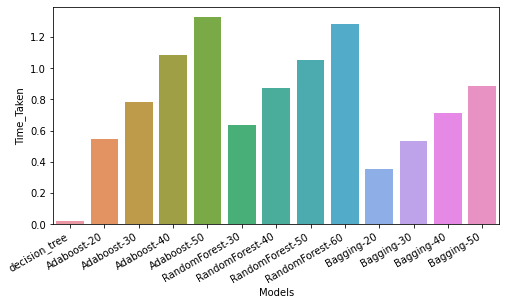

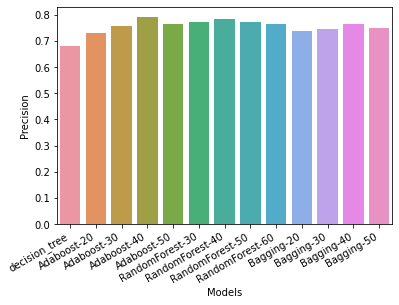

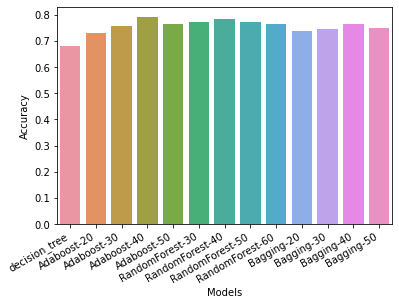

In [ ]:
# create a handler for ensemble_test, use the created handler for fitting different models.
ensemble_handler = EnsembleTest(X_train, y_train, X_test, y_test)
decision = get_weak_learner()
ensemble_handler.fit_model(decision,'decision_tree')

#BEGIN Workspace 3.13.a
#TODO Add multiple instances of the ensemble methods. Plot and compare their performance
ensemble_handler.fit_model(AdaBoost(20),'Adaboost-20')
ensemble_handler.fit_model(AdaBoost(30),'Adaboost-30')
ensemble_handler.fit_model(AdaBoost(40),'Adaboost-40')
ensemble_handler.fit_model(AdaBoost(50),'Adaboost-50')
ensemble_handler.fit_model(RandomForest(30, sample_ratio=0.9, features_ratio=0.8), 'RandomForest-30')
ensemble_handler.fit_model(RandomForest(40, sample_ratio=0.9, features_ratio=0.8), 'RandomForest-40')
ensemble_handler.fit_model(RandomForest(50, sample_ratio=0.9, features_ratio=0.8), 'RandomForest-50')
ensemble_handler.fit_model(RandomForest(60, sample_ratio=0.9, features_ratio=0.8), 'RandomForest-60')
ensemble_handler.fit_model(BaggingEnsemble(20, 0.9),'Bagging-20')
ensemble_handler.fit_model(BaggingEnsemble(30, 0.9),'Bagging-30')
ensemble_handler.fit_model(BaggingEnsemble(40, 0.9),'Bagging-40')
ensemble_handler.fit_model(BaggingEnsemble(50, 0.9),'Bagging-50')


ensemble_handler.print_result()

ensemble_handler.plot_metric()


#END Workspace 3.13.a

#BEGIN Workspace 3.13.b
#TODO Comparison write-up

We can see that the decision tree's accuracy are less than that of the ensemble models (bagging, boosting). Random Forest with 60 estimators seem to slightly perform better than the other models (very slightly). Also Random Forests seems to take slightly lesser time than Adaboost. Because Random Forests are trivially parallelizable the output of one model does not depend on output of other models. Whereas in Adaboost the mistake made by first model will be corrected in the second model therefore it is not trivially parallelizable. It is hard to pick in this case given both Adaboost and Random Forests perform equally good.

#END Workspace 3.13.b